In [1]:
import yfinance as yf
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Download AAPL data
data = yf.download('AAPL', start='2010-01-01', end='2024-12-31', group_by='ticker')




c:\Users\shash\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [2]:
# Fix column names if multi-indexed
if isinstance(data.columns, pd.MultiIndex):
    data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data.columns]

# Prepare DataFrame for Prophet
df = data.reset_index()
df.rename(columns={'Date': 'ds', 'AAPL_Close': 'y'}, inplace=True)
df['ds'] = pd.to_datetime(df['ds'])
df['y'] = pd.to_numeric(df['y'], errors='coerce')
df.dropna(inplace=True)



In [3]:
# Split train-test (training till end of 2023)
train = df[df['ds'] < '2024-01-01']
test = df[df['ds'] >= '2024-01-01']



In [4]:
# Train Prophet model on train set
model = Prophet(
    daily_seasonality=True,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.5,
    changepoint_range=0.9
)
model.fit(train)



13:01:19 - cmdstanpy - INFO - Chain [1] start processing
13:01:22 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
# Forecast over test period
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

# Evaluate performance
forecast_eval = forecast[['ds', 'yhat']].merge(test, on='ds', how='inner')
mae = mean_absolute_error(forecast_eval['y'], forecast_eval['yhat'])
rmse = np.sqrt(mean_squared_error(forecast_eval['y'], forecast_eval['yhat']))
mape = np.mean(np.abs((forecast_eval['y'] - forecast_eval['yhat']) / forecast_eval['y'])) * 100

print(f"\n Evaluation on 2024:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")




 Evaluation on 2024:
MAE:  11.31
RMSE: 14.37
MAPE: 6.10%


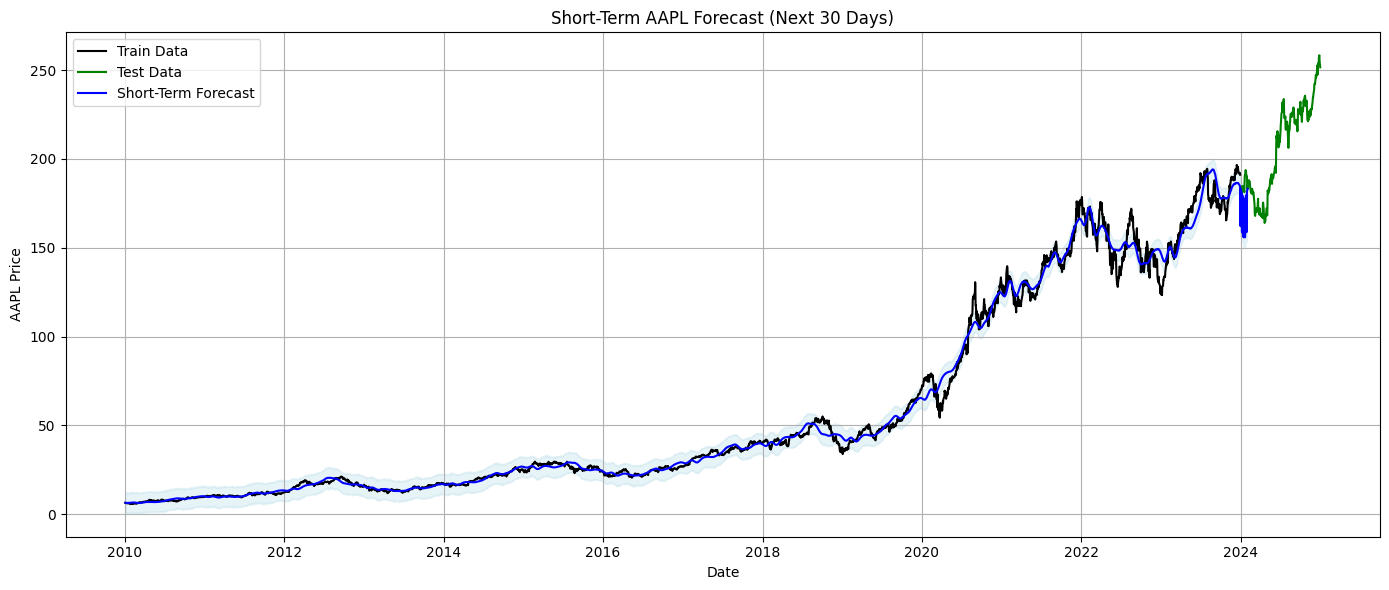

In [6]:


short_term_days = 30
short_term_limit = test['ds'].min() + pd.Timedelta(days=short_term_days)
forecast_short_term = forecast[forecast['ds'] <= short_term_limit]
forecast_long_term = forecast[forecast['ds'] > short_term_limit]

# 1. Short-term forecast plot
plt.figure(figsize=(14, 6))
plt.plot(train['ds'], train['y'], label='Train Data', color='black')
plt.plot(test['ds'], test['y'], label='Test Data', color='green')
plt.plot(forecast_short_term['ds'], forecast_short_term['yhat'], label='Short-Term Forecast', color='blue')
plt.fill_between(forecast_short_term['ds'], forecast_short_term['yhat_lower'], forecast_short_term['yhat_upper'],
                 color='lightblue', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('AAPL Price')
plt.title('Short-Term AAPL Forecast (Next 30 Days)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




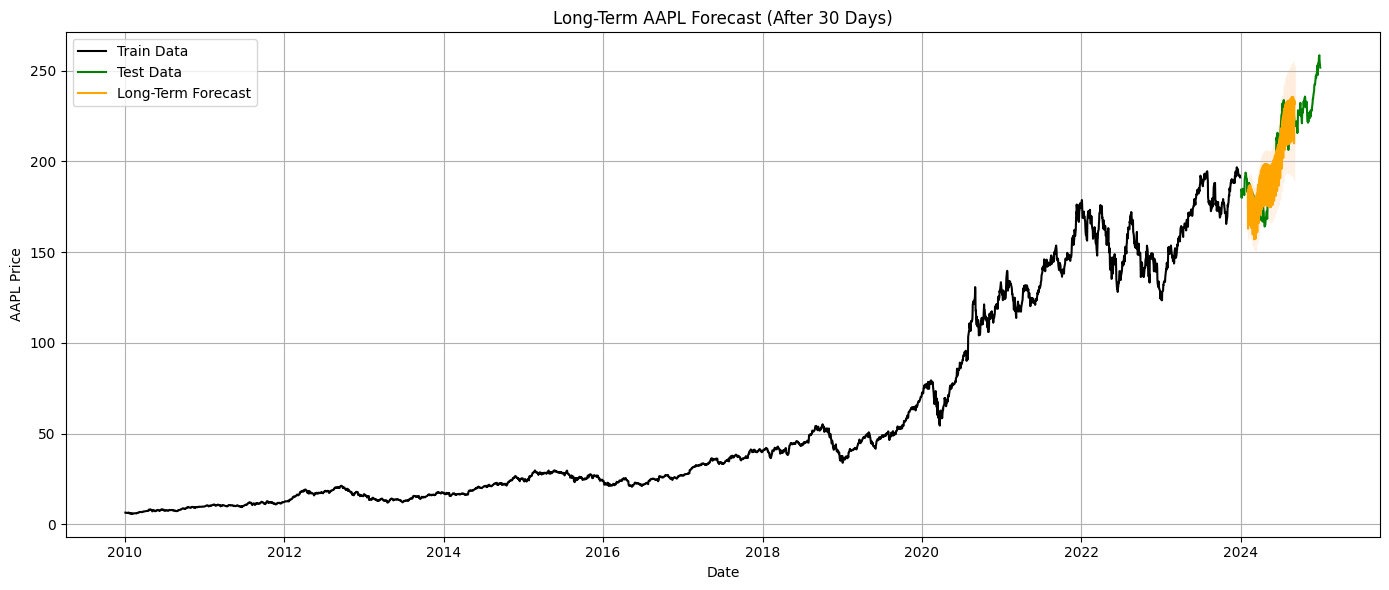

In [7]:
# 2. Long-term forecast plot
plt.figure(figsize=(14, 6))
plt.plot(train['ds'], train['y'], label='Train Data', color='black')
plt.plot(test['ds'], test['y'], label='Test Data', color='green')
plt.plot(forecast_long_term['ds'], forecast_long_term['yhat'], label='Long-Term Forecast', color='orange')
plt.fill_between(forecast_long_term['ds'], forecast_long_term['yhat_lower'], forecast_long_term['yhat_upper'],
                 color='peachpuff', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('AAPL Price')
plt.title('Long-Term AAPL Forecast (After 30 Days)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



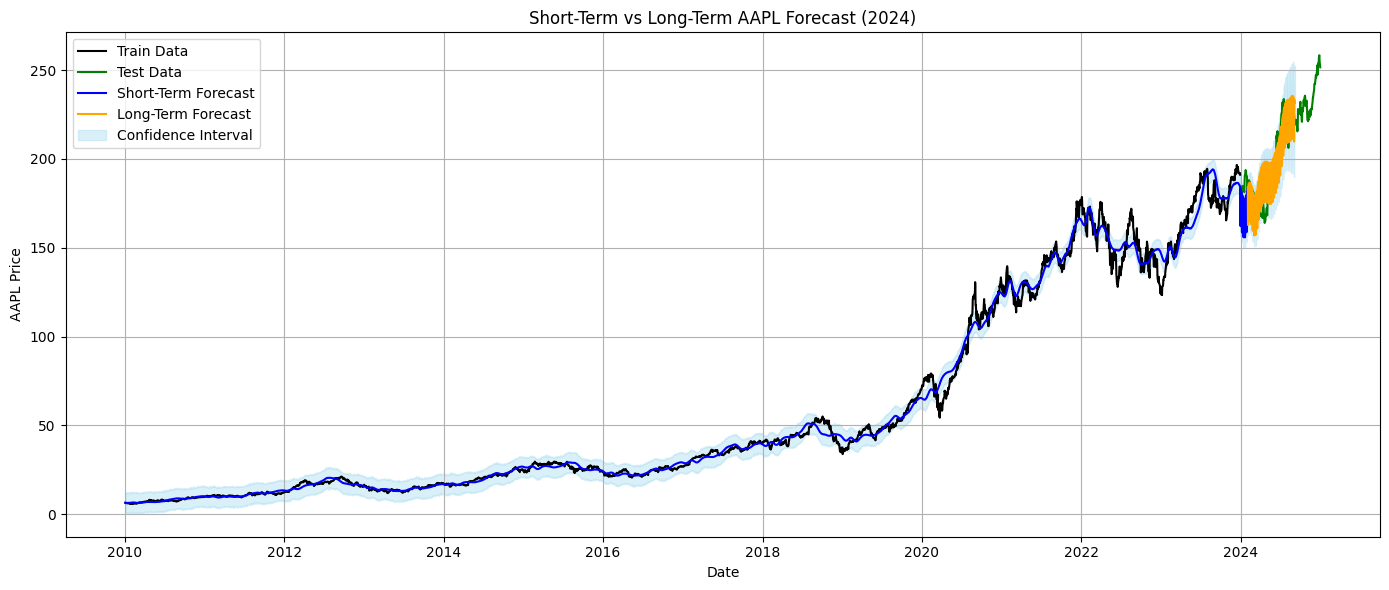

In [8]:
# 3. Combined plot (your existing one)
plt.figure(figsize=(14, 6))
plt.plot(train['ds'], train['y'], label='Train Data', color='black')
plt.plot(test['ds'], test['y'], label='Test Data', color='green')
plt.plot(forecast_short_term['ds'], forecast_short_term['yhat'], label='Short-Term Forecast', color='blue')
plt.plot(forecast_long_term['ds'], forecast_long_term['yhat'], label='Long-Term Forecast', color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                 color='skyblue', alpha=0.3, label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('AAPL Price')
plt.title('Short-Term vs Long-Term AAPL Forecast (2024)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


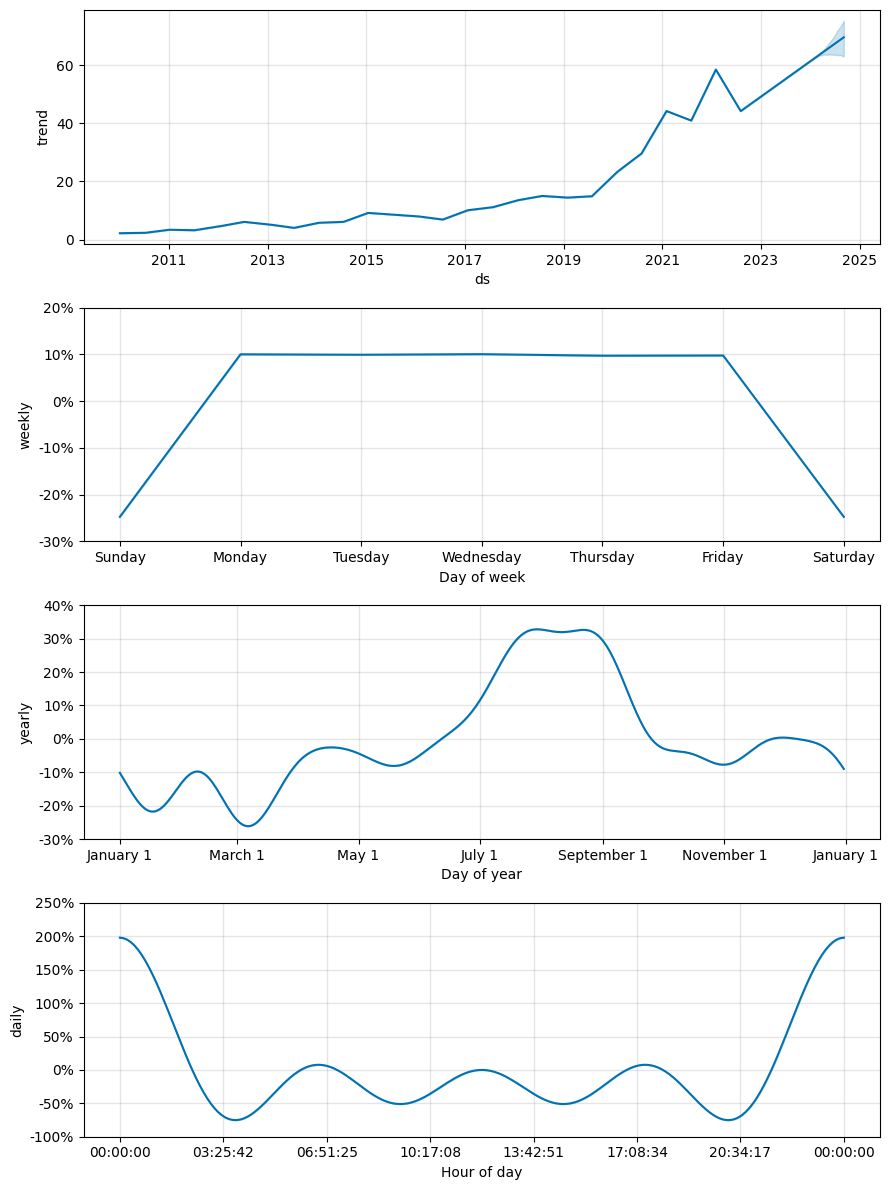

In [9]:

# seasonality and trend components
model.plot_components(forecast)
plt.tight_layout()
plt.show()

Train Full Dataset( seasonality_mode='additive',)

13:02:42 - cmdstanpy - INFO - Chain [1] start processing
13:02:45 - cmdstanpy - INFO - Chain [1] done processing


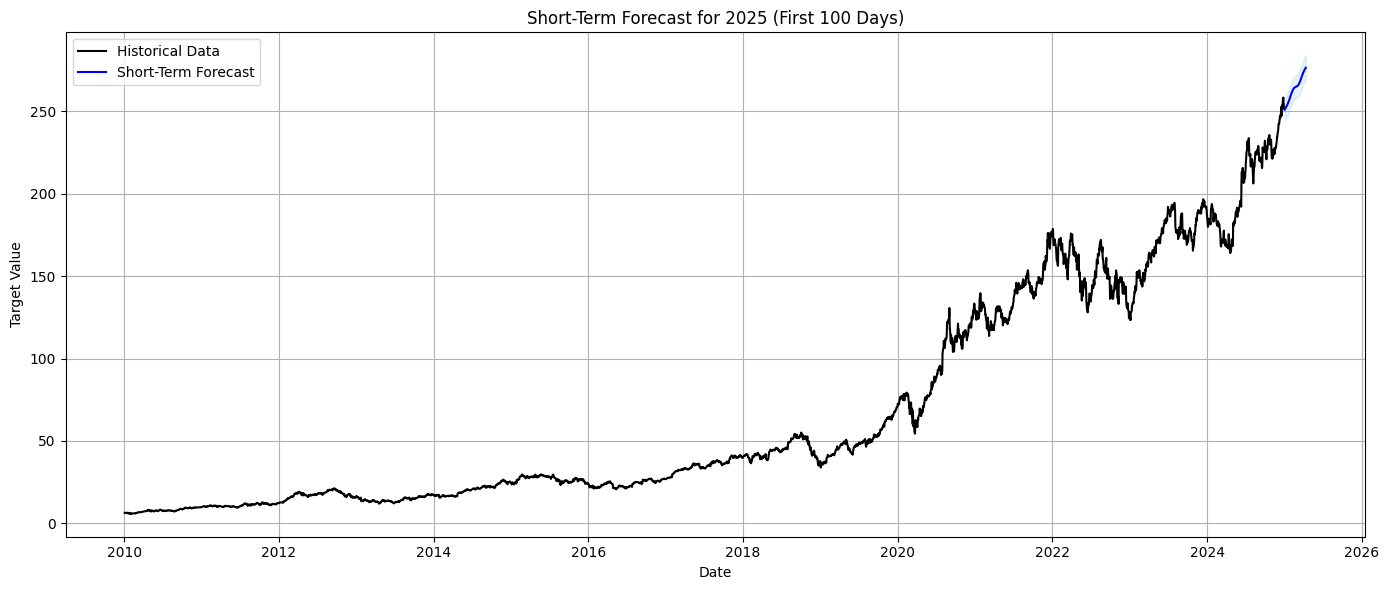

In [11]:
# Train on full dataset
final_model = Prophet(
    daily_seasonality=True,
    seasonality_mode='additive',
    changepoint_prior_scale=0.1,
    changepoint_range=0.95
)
final_model.fit(df)

# Make forecast for 2025 (adjust periods as needed)
future = final_model.make_future_dataframe(periods=365)
forecast_2025 = final_model.predict(future)

# Split forecast
short_term_days = 100
start_2025 = pd.Timestamp('2025-01-01')
short_term_limit = start_2025 + pd.Timedelta(days=short_term_days)

forecast_short_term = forecast_2025[(forecast_2025['ds'] >= start_2025) & (forecast_2025['ds'] <= short_term_limit)]
forecast_long_term = forecast_2025[forecast_2025['ds'] > short_term_limit]

# Plot short-term forecast
plt.figure(figsize=(14, 6))
plt.plot(df['ds'], df['y'], label='Historical Data', color='black')
plt.plot(forecast_short_term['ds'], forecast_short_term['yhat'], label='Short-Term Forecast', color='blue')
plt.fill_between(forecast_short_term['ds'], forecast_short_term['yhat_lower'], forecast_short_term['yhat_upper'],
                 color='lightblue', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Target Value')  # or 'AAPL Price' if appropriate
plt.title('Short-Term Forecast for 2025 (First 100 Days)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


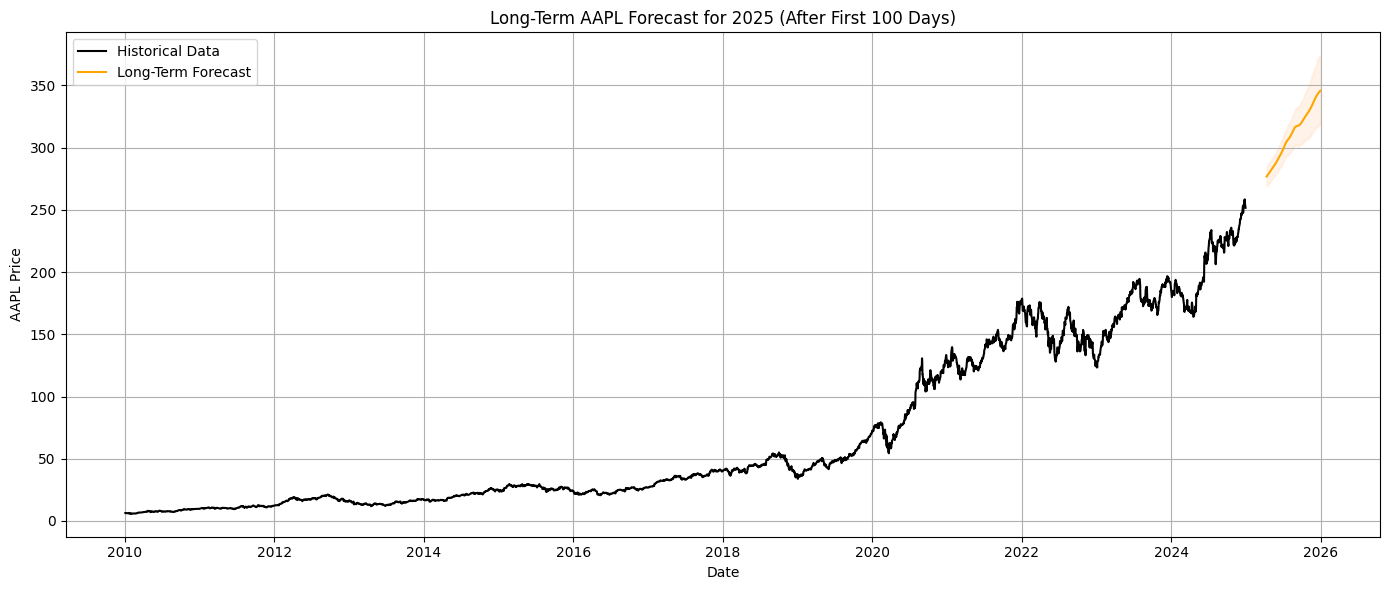

In [12]:
# 2. Long-term forecast plot (Remaining days of 2025 after 100 days)
plt.figure(figsize=(14, 6))
plt.plot(df['ds'], df['y'], label='Historical Data', color='black')
plt.plot(forecast_long_term['ds'], forecast_long_term['yhat'], label='Long-Term Forecast', color='orange')
plt.fill_between(forecast_long_term['ds'], forecast_long_term['yhat_lower'], forecast_long_term['yhat_upper'],
                 color='peachpuff', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('AAPL Price')
plt.title('Long-Term AAPL Forecast for 2025 (After First 100 Days)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




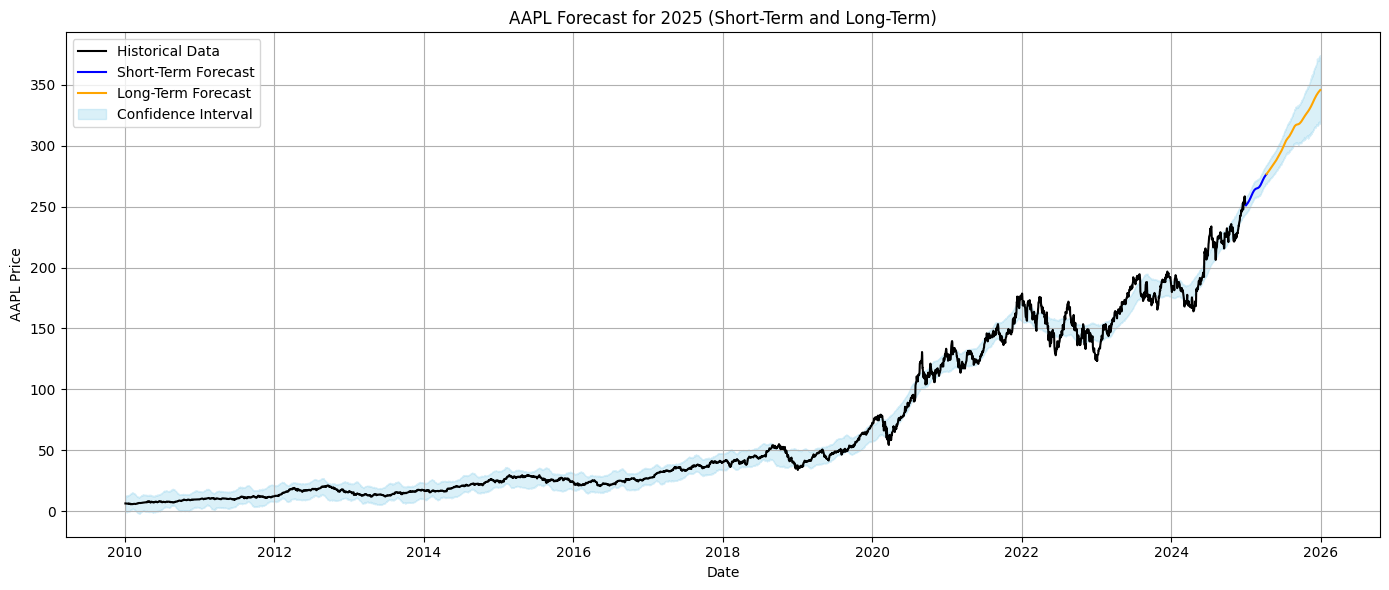

In [13]:
# 3. Combined forecast plot (Full 2025 forecast)
plt.figure(figsize=(14, 6))
plt.plot(df['ds'], df['y'], label='Historical Data', color='black')
plt.plot(forecast_short_term['ds'], forecast_short_term['yhat'], label='Short-Term Forecast', color='blue')
plt.plot(forecast_long_term['ds'], forecast_long_term['yhat'], label='Long-Term Forecast', color='orange')
plt.fill_between(forecast_2025['ds'], forecast_2025['yhat_lower'], forecast_2025['yhat_upper'],
                 color='skyblue', alpha=0.3, label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('AAPL Price')
plt.title('AAPL Forecast for 2025 (Short-Term and Long-Term)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




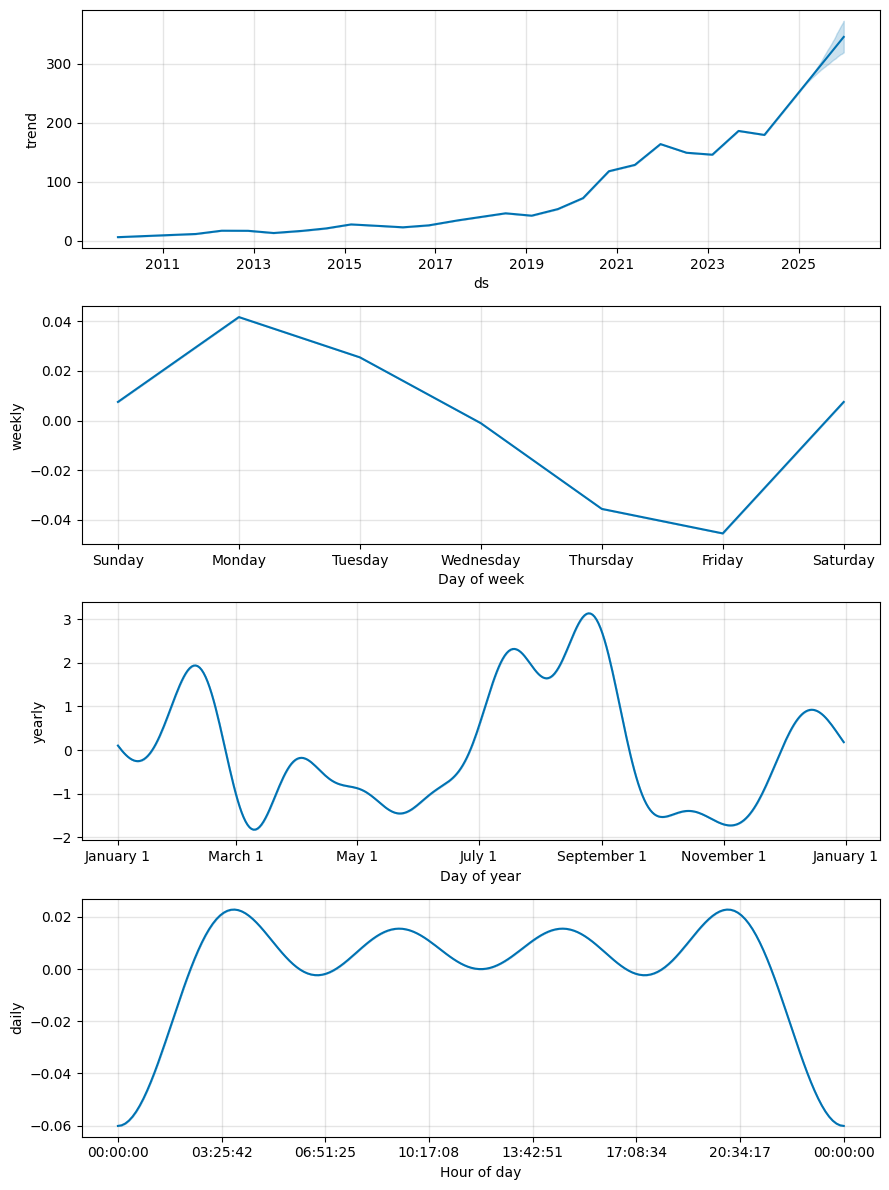

In [14]:
# seasonality and trend components
final_model.plot_components(forecast_2025)
plt.tight_layout()
plt.show()

Train Full Dataset( seasonality_mode='multiplicative',)

13:04:13 - cmdstanpy - INFO - Chain [1] start processing
13:04:16 - cmdstanpy - INFO - Chain [1] done processing


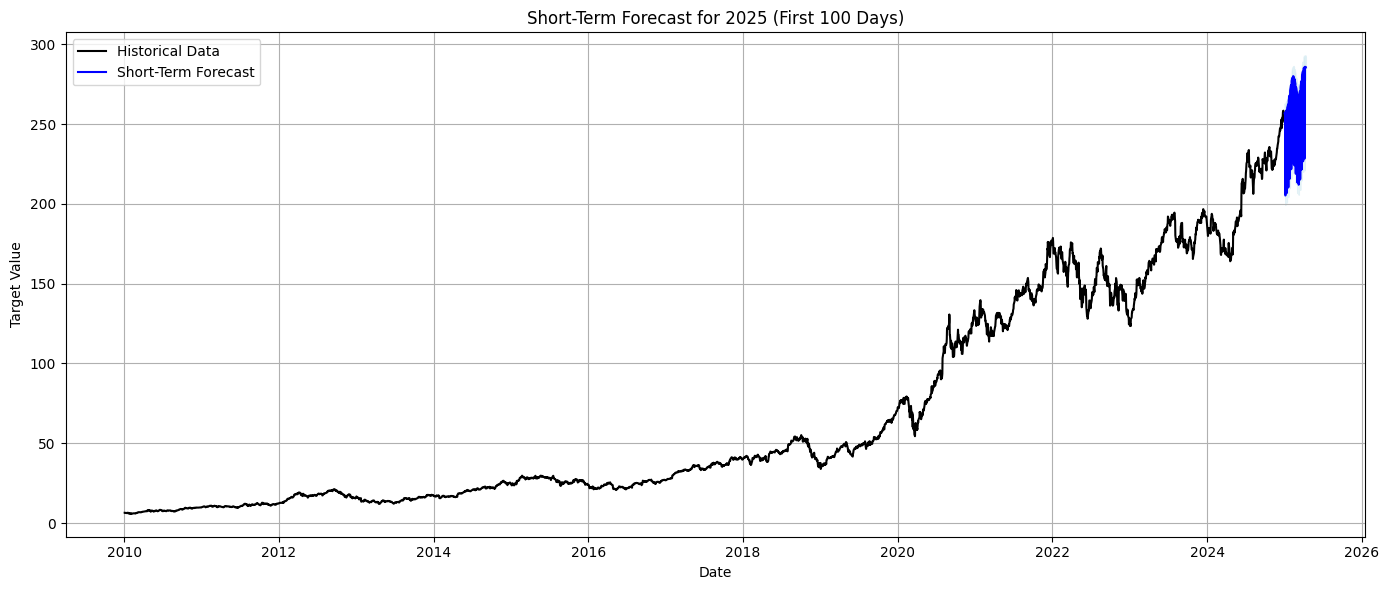

In [15]:

# Train on full dataset
final_model = Prophet(
    daily_seasonality=True,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.1,
    changepoint_range=0.95
)
final_model.fit(df)

# Make forecast for 2025 (adjust periods as needed)
future = final_model.make_future_dataframe(periods=365)
forecast_2025 = final_model.predict(future)

# Split forecast
short_term_days = 100
start_2025 = pd.Timestamp('2025-01-01')
short_term_limit = start_2025 + pd.Timedelta(days=short_term_days)

forecast_short_term = forecast_2025[(forecast_2025['ds'] >= start_2025) & (forecast_2025['ds'] <= short_term_limit)]
forecast_long_term = forecast_2025[forecast_2025['ds'] > short_term_limit]

# Plot short-term forecast
plt.figure(figsize=(14, 6))
plt.plot(df['ds'], df['y'], label='Historical Data', color='black')
plt.plot(forecast_short_term['ds'], forecast_short_term['yhat'], label='Short-Term Forecast', color='blue')
plt.fill_between(forecast_short_term['ds'], forecast_short_term['yhat_lower'], forecast_short_term['yhat_upper'],
                 color='lightblue', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Target Value')  # or 'AAPL Price' if appropriate
plt.title('Short-Term Forecast for 2025 (First 100 Days)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


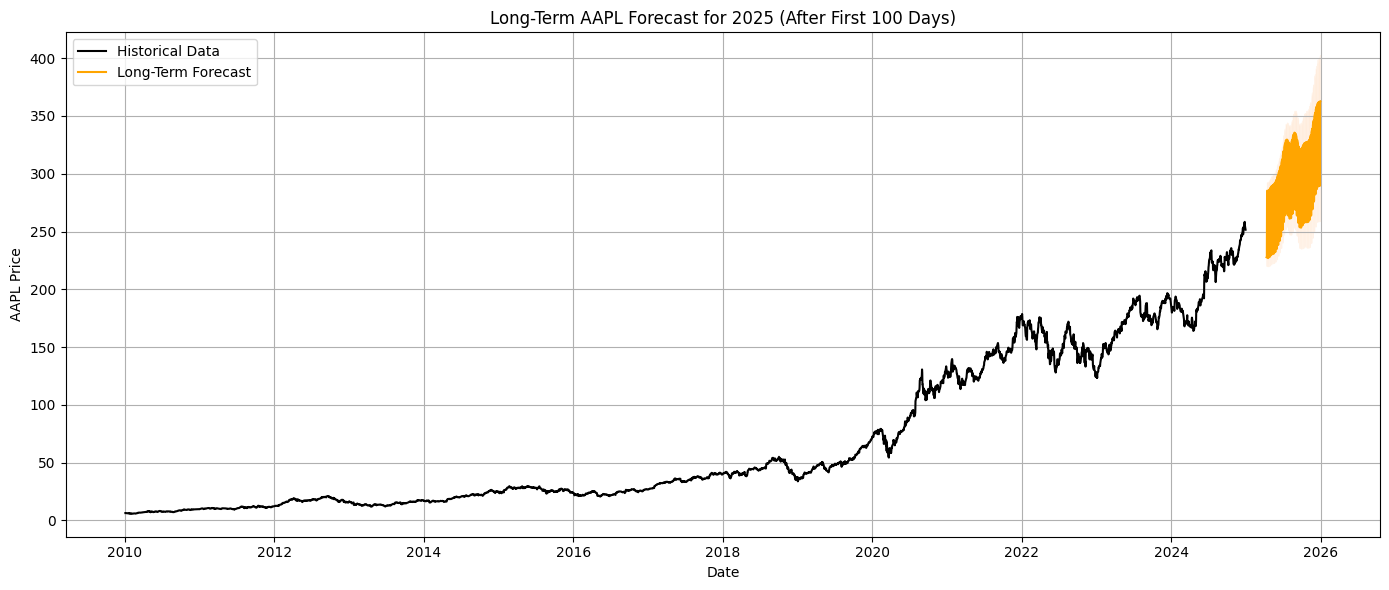

In [16]:
# 2. Long-term forecast plot (Remaining days of 2025 after 100 days)
plt.figure(figsize=(14, 6))
plt.plot(df['ds'], df['y'], label='Historical Data', color='black')
plt.plot(forecast_long_term['ds'], forecast_long_term['yhat'], label='Long-Term Forecast', color='orange')
plt.fill_between(forecast_long_term['ds'], forecast_long_term['yhat_lower'], forecast_long_term['yhat_upper'],
                 color='peachpuff', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('AAPL Price')
plt.title('Long-Term AAPL Forecast for 2025 (After First 100 Days)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




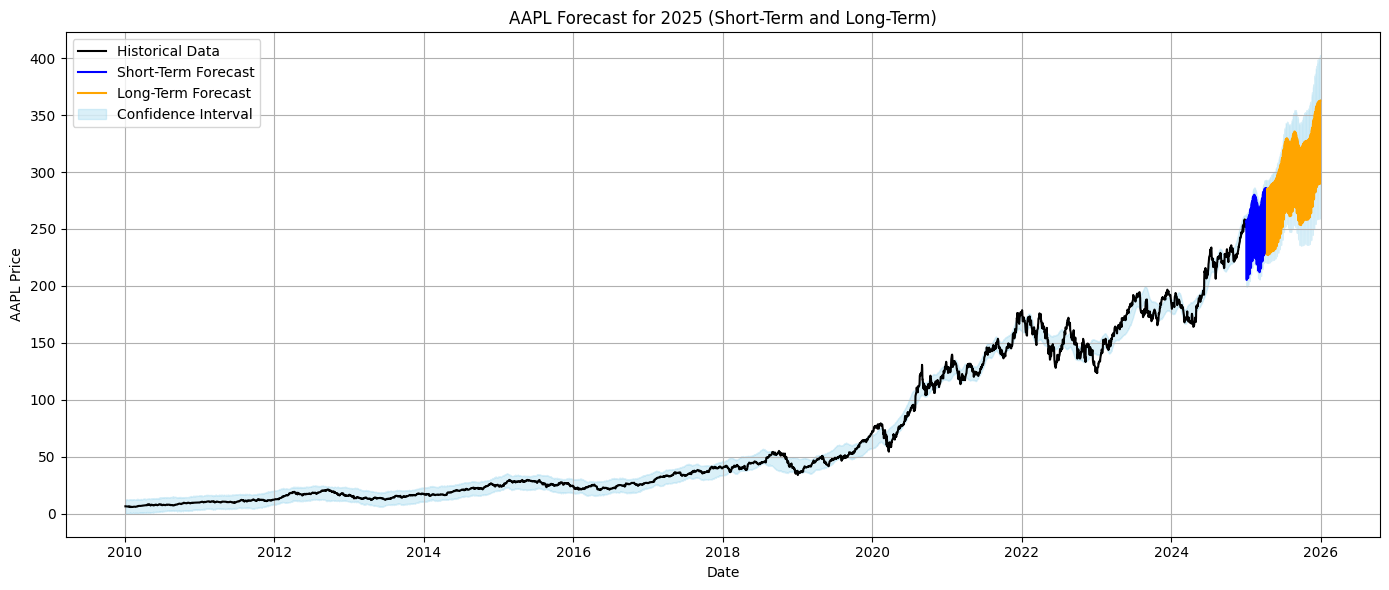

In [17]:
# 3. Combined forecast plot (Full 2025 forecast)
plt.figure(figsize=(14, 6))
plt.plot(df['ds'], df['y'], label='Historical Data', color='black')
plt.plot(forecast_short_term['ds'], forecast_short_term['yhat'], label='Short-Term Forecast', color='blue')
plt.plot(forecast_long_term['ds'], forecast_long_term['yhat'], label='Long-Term Forecast', color='orange')
plt.fill_between(forecast_2025['ds'], forecast_2025['yhat_lower'], forecast_2025['yhat_upper'],
                 color='skyblue', alpha=0.3, label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('AAPL Price')
plt.title('AAPL Forecast for 2025 (Short-Term and Long-Term)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




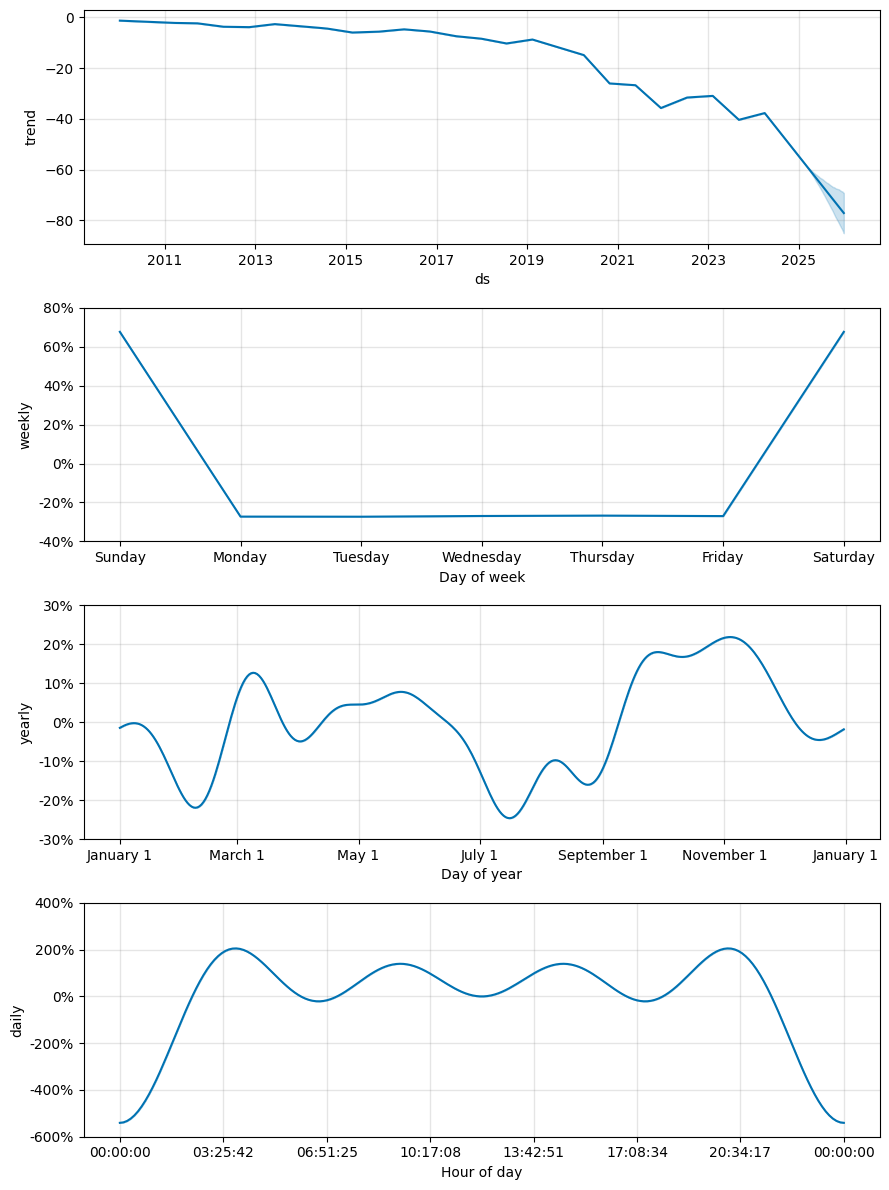

In [18]:
# seasonality and trend components
final_model.plot_components(forecast_2025)
plt.tight_layout()
plt.show()